In [11]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import plotly.express as px
from sklearn.model_selection import cross_val_score
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.datasets import make_classification

In [2]:
import pandas as pd
df = pd.read_csv("retouren.csv")
df["user_dob"] = pd.to_datetime(df.user_dob)
df["user_reg_date"] = pd.to_datetime(df.user_reg_date)
df["order_date"] = pd.to_datetime(df.order_date)
df["delivery_date"] = pd.to_datetime(df.delivery_date)
df = df.drop(df[df.item_price == 999].index)
df = df.drop(df[df.delivery_date < df.order_date].index)
df = df.drop(df[df.item_color == "?"].index)
df.loc[df.item_color == "brwon","item_color"] = "brown"
df.loc[df.item_color == "blau","item_color"] = "blue"
df.loc[df.item_color == "dark oliv","item_color"] = "dark olive"
df["age"] = df.order_date.dt.year - df.user_dob.dt.year -((df.order_date.dt.date)<(df.user_dob.dt.date))
df["acc_age"] = df.order_date - df.user_reg_date 
df["acc_age"] = df.acc_age.dt.days
df_mark = df.groupby(["item_id","item_size","item_color"]).agg(maxprice=("item_price","max")).reset_index()
df = pd.merge(df,df_mark)
df["markdown"] = 0
df.loc[df.item_price < df.maxprice,"markdown"] = 1
df.drop(df[df.delivery_date.isna()].index, inplace=True)

In [3]:
df.loc[df.age > 100, "age"] = df.loc[df.age > 100, "age"] - 100
bins=[0,10,20,30,40,50,60,70,80,90,100]
df["age"] = pd.cut(df.age,bins=bins)

In [64]:
df = pd.get_dummies(df[["item_id", 	"brand_id",	"item_price",	"user_id",	"user_title",	"user_state",	"markdown", "age"]],dummy_na=True)

In [65]:
df

,item_id,brand_id,item_price,user_id,markdown,user_title_Company,user_title_Family,user_title_Mr,user_title_Mrs,user_title_not reported,...,"age_(10.0, 20.0]","age_(20.0, 30.0]","age_(30.0, 40.0]","age_(40.0, 50.0]","age_(50.0, 60.0]","age_(60.0, 70.0]","age_(70.0, 80.0]","age_(80.0, 90.0]","age_(90.0, 100.0]",age_nan
0,643,30,49.90,30822,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,643,30,49.90,29306,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
3,270,49,79.90,30823,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,270,49,79.90,11260,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
5,270,49,79.90,1283,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74073,1623,46,39.90,2652,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
74074,1740,36,79.90,42536,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
74075,1483,17,134.90,42536,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
74076,2155,27,14.95,43801,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [30]:
df.groupby("return")[["return"]].count()

,return
return,
0,32696
1,33414


In [68]:
df

,order_item_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return,age,acc_age,maxprice,markdown
0,1,2016-06-22,2016-06-27,643,38,navy,30,49.90,30822,Mrs,1969-04-17,Saxony,2016-06-23,0,"(40, 50]",-1,49.90,0
1,763,2016-06-24,2016-06-26,643,38,navy,30,49.90,29306,Mrs,1973-06-17,Schleswig-Holstein,2016-06-17,0,"(40, 50]",7,49.90,0
3,3,2016-06-22,2016-06-27,270,xxl,grey,49,79.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1,"(40, 50]",465,79.90,0
4,522,2016-06-23,2016-06-26,270,xxl,grey,49,79.90,11260,Mrs,1950-11-21,North Rhine-Westphalia,2015-04-24,0,"(60, 70]",426,79.90,0
5,25884,2016-07-03,2016-07-04,270,xxl,grey,49,79.90,1283,Mrs,1967-01-12,Schleswig-Holstein,2015-09-15,1,"(40, 50]",292,79.90,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74073,74976,2016-08-20,2016-08-21,1623,l,mocca,46,39.90,2652,Mrs,1976-09-16,Thuringia,2015-09-08,0,"(30, 40]",347,39.90,0
74074,74978,2016-08-20,2016-08-22,1740,l,blue,36,79.90,42536,Mr,1964-12-16,Hamburg,2016-02-07,0,"(50, 60]",195,79.90,0
74075,74981,2016-08-20,2016-08-22,1483,39,blue,17,134.90,42536,Mr,1964-12-16,Hamburg,2016-02-07,1,"(50, 60]",195,134.90,0
74076,75004,2016-08-20,2016-08-21,2155,39,white,27,14.95,43801,Mrs,1961-11-25,Mecklenburg-Western Pomerania,2016-08-21,1,"(50, 60]",-1,14.95,0


In [4]:
#Trainingsdaten
X = pd.get_dummies(df[["item_id", "item_color",	"brand_id",	"item_price",	"user_id",	"user_title",	"user_state",	"markdown", "age","acc_age", "item_size" ]])
y = df["return"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [27]:
X_train

,item_id,brand_id,item_price,user_id,markdown,item_color_almond,item_color_amethyst,item_color_ancient,item_color_anthracite,item_color_antique pink,...,user_state_Hesse,user_state_Lower Saxony,user_state_Mecklenburg-Western Pomerania,user_state_North Rhine-Westphalia,user_state_Rhineland-Palatinate,user_state_Saarland,user_state_Saxony,user_state_Saxony-Anhalt,user_state_Schleswig-Holstein,user_state_Thuringia
5061,114,43,79.9,41363,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
52884,1687,3,39.9,40378,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
59665,1552,49,199.9,22100,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
45698,1359,51,44.9,34058,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
63563,1958,11,69.9,40844,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48711,1550,117,129.9,6301,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
24679,328,37,19.9,22407,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
52790,1636,113,69.9,23933,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
49357,1569,11,69.9,20074,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [5]:
#Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.
#You can grid search over parameters of all estimators in the pipeline at once.
#You only have to call fit and predict once on your data to fit a whole sequence of estimators.

pipe = make_pipeline(StandardScaler(),
                     #SVC(cache_size=800,kernel="poly")
                     LinearSVC( tol=1e-5,dual=False,max_iter=10000)
                     )

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.score


In [28]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC(C=5))])

In [29]:
y_predict = pipe.predict(X_test)

In [15]:
y_predict

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [16]:
y_test

65698    0
59855    0
28923    0
37197    0
72805    0
        ..
64716    1
29660    0
48758    0
38099    1
27608    1
Name: return, Length: 13222, dtype: int64

In [17]:
#pipe.score(X_train,y_train,0.2)

In [30]:
acc_score = accuracy_score(y_predict,y_test)
print('accuracy score : ',acc_score)

accuracy score :  0.5665557404326124


In [19]:
#cv = ShuffleSplit(n_splits=10, test_size=0.2)

In [22]:
scores = cross_val_score(pipe, X_train, y_train,n_jobs=4,scoring="accuracy")

ValueError: 'accuracy_score' is not a valid scoring value. Use sklearn.metrics.get_scorer_names() to get valid options.

In [25]:
sklearn.metrics.get_scorer_names()
#cross_validate https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [21]:
print(scores)

[0.53214218 0.52410664 0.53195311 0.52878888 0.51801078]


https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC

https://scikit-learn.org/stable/modules/svm.html#svm-kernels

https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py

https://scikit-learn.org/stable/modules/compose.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

https://scikit-learn.org/stable/modules/grid_search.html#grid-search

In [19]:
X_train

,item_id,brand_id,item_price,user_id,markdown,item_color_almond,item_color_amethyst,item_color_ancient,item_color_anthracite,item_color_antique pink,...,user_state_Hesse,user_state_Lower Saxony,user_state_Mecklenburg-Western Pomerania,user_state_North Rhine-Westphalia,user_state_Rhineland-Palatinate,user_state_Saarland,user_state_Saxony,user_state_Saxony-Anhalt,user_state_Schleswig-Holstein,user_state_Thuringia
5061,114,43,79.9,41363,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
52884,1687,3,39.9,40378,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
59665,1552,49,199.9,22100,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
45698,1359,51,44.9,34058,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
63563,1958,11,69.9,40844,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48711,1550,117,129.9,6301,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
24679,328,37,19.9,22407,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
52790,1636,113,69.9,23933,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
49357,1569,11,69.9,20074,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [6]:
param_grid = {
    "linearsvc__C": np.linspace(0.001, 3, 20),
    #"svc__C": np.logspace(0.1, 20, 5)
    #"linearsvc__class_weight": [None,{1: 0.8,0:1},{1: 0.6,0:1},{1: 0.4,0:1}]
}
grid = GridSearchCV(pipe,param_grid,scoring="accuracy",n_jobs=8,return_train_score=True)

In [7]:
grid.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('linearsvc',
                                        LinearSVC(dual=False, max_iter=10000,
                                                  tol=1e-05))]),
             n_jobs=8,
             param_grid={'linearsvc__C': array([1.00000000e-03, 1.58842105e-01, 3.16684211e-01, 4.74526316e-01,
       6.32368421e-01, 7.90210526e-01, 9.48052632e-01, 1.10589474e+00,
       1.26373684e+00, 1.42157895e+00, 1.57942105e+00, 1.73726316e+00,
       1.89510526e+00, 2.05294737e+00, 2.21078947e+00, 2.36863158e+00,
       2.52647368e+00, 2.68431579e+00, 2.84215789e+00, 3.00000000e+00])},
             return_train_score=True, scoring='accuracy')

In [57]:
np.linspace(0.001, 3, 20)

array([1.00000000e-03, 1.58842105e-01, 3.16684211e-01, 4.74526316e-01,
       6.32368421e-01, 7.90210526e-01, 9.48052632e-01, 1.10589474e+00,
       1.26373684e+00, 1.42157895e+00, 1.57942105e+00, 1.73726316e+00,
       1.89510526e+00, 2.05294737e+00, 2.21078947e+00, 2.36863158e+00,
       2.52647368e+00, 2.68431579e+00, 2.84215789e+00, 3.00000000e+00])

In [76]:
print("Best parameter (CV score=%0.3f):" % grid.best_score_)
print(grid.best_params_)

Best parameter (CV score=0.573):
{'linearsvc__C': 0.001}


In [8]:
#bestes modell mit C = 0.001
pipe = make_pipeline(StandardScaler(),
                     #SVC(cache_size=800,kernel="poly")
                     LinearSVC( tol=1e-5,dual=False,max_iter=10000,C=0.001)
                     )
pipe.fit(X_train,y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=0.001, dual=False, max_iter=10000, tol=1e-05))])

In [13]:
clf = CalibratedClassifierCV(pipe,cv="prefit")
clf.fit(X_train,y_train)


CalibratedClassifierCV(base_estimator=Pipeline(steps=[('standardscaler',
                                                       StandardScaler()),
                                                      ('linearsvc',
                                                       LinearSVC(C=0.001,
                                                                 dual=False,
                                                                 max_iter=10000,
                                                                 tol=1e-05))]),
                       cv='prefit')

In [14]:
y_pred = clf.predict(X_train)
acc_score = accuracy_score(y_train,y_pred)
print('accuracy score : ',acc_score)

accuracy score :  0.5790538496445319


In [15]:
y_predict = clf.predict(X_test)
acc_score = accuracy_score(y_predict,y_test)
print('accuracy score : ',acc_score)

accuracy score :  0.575404628649221


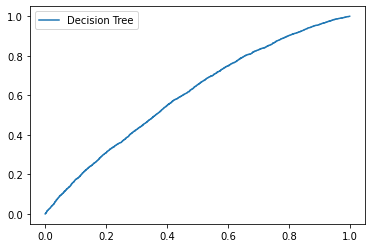

In [16]:

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
#fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, m_lr.predict_proba(X_test)[:,1])

plt.step(x=fpr_dt, y=tpr_dt, label="Decision Tree")
#plt.step(x=fpr_lr, y=tpr_lr, label="Logistic Regression")
plt.legend()

In [82]:
y_pred = pipe.predict(X_train)
acc_score = accuracy_score(y_train,y_pred)
print('accuracy score : ',acc_score)

accuracy score :  0.5790727575253366


In [79]:
y_predict = pipe.predict(X_test)
acc_score = accuracy_score(y_predict,y_test)
print('accuracy score : ',acc_score)

accuracy score :  0.5753289971260022


In [83]:
recall = recall_score(y_train, y_pred)
print(recall)

0.5909652307346832


In [84]:
recall = recall_score(y_test, y_predict)
print(recall)

0.5913368185212845


In [85]:
prec = precision_score(y_train, y_pred)
print(prec)

0.5821627401098699


In [86]:
prec = precision_score(y_test, y_predict)
print(prec)

0.5789704591985961


für aufgabe 6 comparison y_test und y_predict nur die 1 wenn tatsächlich 1 dann +3,5 wenn nicht dann minus 0,1*item_price

In [87]:
y_predict

array([0, 1, 1, ..., 0, 1, 1], dtype=int64)

In [88]:
y_test

65698    0
59855    0
28923    0
37197    0
72805    0
        ..
64716    1
29660    0
48758    0
38099    1
27608    1
Name: return, Length: 13222, dtype: int64

In [95]:
X_test["return1"] = y_predict

In [92]:
X_test["return_true"] = y_test

In [96]:
X_test["idk"] = X_test.return1 == X_test.return_true

In [98]:
df_aufgabe6 = X_test[X_test.return1 == 1]

In [100]:
df_aufgabe6["sum"] = 0

C:\Users\paulh\AppData\Local\Temp\ipykernel_464\766378953.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aufgabe6["sum"] = 0


In [103]:
df_aufgabe6.loc[df_aufgabe6.idk == True,"sum"]  = 3.5

C:\Users\paulh\AppData\Local\Temp\ipykernel_464\287104434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aufgabe6.loc[df_aufgabe6.idk == True,"sum"]  = 3.5


In [108]:
df_aufgabe6.loc[df_aufgabe6.idk == False,"sum"] = df_aufgabe6.item_price*(-0.1)*0.5

In [109]:
df_aufgabe6

,item_id,brand_id,item_price,user_id,markdown,acc_age,item_color_almond,item_color_amethyst,item_color_ancient,item_color_anthracite,...,item_size_unsized,item_size_xl,item_size_xs,item_size_xxl,item_size_xxxl,return,return_true,return1,idk,sum
59855,1518,37,39.9,9643,0,429,0,0,0,0,...,0,0,0,0,0,1,0,1,False,-1.995
28923,676,19,49.9,35437,1,-1,0,0,0,0,...,0,0,0,0,0,1,0,1,False,-2.495
72805,1497,1,129.9,13729,0,279,0,0,0,0,...,0,0,0,0,0,1,0,1,False,-6.495
73672,1558,1,169.9,43231,0,547,0,0,0,0,...,0,0,0,0,0,1,1,1,True,3.500
45119,58,31,89.9,36053,0,507,0,0,0,0,...,0,0,0,1,0,1,1,1,True,3.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54000,1666,36,99.9,40193,0,340,0,0,0,0,...,0,0,0,0,0,1,0,1,False,-4.995
55407,1863,12,170.0,12045,0,521,0,0,0,0,...,0,0,0,0,0,1,1,1,True,3.500
64716,1903,113,69.9,20258,0,541,0,0,0,0,...,0,0,0,0,0,1,1,1,True,3.500
38099,185,11,44.9,7991,1,547,0,0,0,0,...,0,0,0,0,0,1,1,1,True,3.500


In [110]:
df_aufgabe6["sum"].sum()

2014.9414999999983